In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.nn import functional
import math

# Hyper-parameters 
input_size = 784
num_classes = 10
num_epochs = 1
batch_size = 32
learning_rate = 1e-3

# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ]))

In [2]:
# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Binary ops

In [3]:
class Binarize(torch.autograd.Function):
    THRESHOLD_STE = True
    
    @staticmethod
    def forward(ctx, input):
        """
        We approximate the input by the following:
        
        input ~= sign(input) * l1_norm(input) / input.size
        """
        ctx.save_for_backward(input)
        return input.sign() * torch.mean(torch.abs(input))

    @staticmethod
    def backward(ctx, grad_output):
        """
        According to [Do-Re-Fa Networks](https://arxiv.org/pdf/1606.06160.pdf),
        the STE for binary weight networks is completely pass through.
        
        However, according to [Binary Neural Networks](https://arxiv.org/pdf/1602.02830.pdf),
        and [XNOR-net networks](https://arxiv.org/pdf/1603.05279.pdf),
        the STE must be thresholded by the following:
        
        d = d * (-1 <= w <= 1)
        
        Set THRESHOLD_STE to True/False for either behavior. However, it is suggested
        to set it to True because we have seen performance degradations with it = False.
        """
        if Binarize.THRESHOLD_STE:
            input, = ctx.saved_tensors
            grad_output[input.ge(1)] = 0
            grad_output[input.le(-1)] = 0
        return grad_output

class BinaryLinear(nn.Module):
    def __init__(self, in_features, out_features):
        """
        Takes in some inputs x, and initializes some weights for matmul,
        and performs a bitcount(xor(x, weights)).
        
        input = (N, M)
        weights = (M, K)
        
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``
        """
        super(BinaryLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        
        # Initializing parameters
        stdv = 1. / math.sqrt(in_features * out_features)
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)        

    def forward(self, input):
        binarize = Binarize.apply
        return functional.linear(input, self.weight, self.bias)
        
class BinaryConvolution2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=True):
        """
        Takes in some inputs x, and initializes some weights for conv filters,
        and performs a "convolution" by binarizing the weights and multiplying
        the inputs by the binarized weights.
        
        input = (N, C, H, W)
        weights = (K, C, H, W) [ to be binarized ]
        biases = (K,) [ to be binarized ]
        output = (N, K, H, W)
        
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int or tuple, optional): Zero-padding added to both sides of the input. Default: 0
        bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
        
        NOTE: We skip dilation, groups, etc for now.
        """
        super(BinaryConvolution2d, self).__init__()
        self.weight = torch.nn.Parameter(torch.Tensor(out_channels, in_channels, *(kernel_size, kernel_size)))
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.stride = stride
        self.padding = padding
        
        # Initializing parameters
        n = in_channels
        n *= kernel_size ** 2 # number of parameters
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)
        
    def forward(self, input):
        binarize = Binarize.apply
        return functional.conv2d(input, self.weight, self.bias, self.stride, self.padding)

# Testing

In [4]:
# Testing Binarize:
# Create random Tensors to hold input and outputs.
x = torch.randn(1, 3, requires_grad=True)
w = torch.randn(1, 3, requires_grad=True)
b = torch.randn(1, 1, requires_grad=True)

binarize = Binarize.apply

# Forward pass: compute predicted y using operations; we compute
# ReLU using our custom autograd operation.
for _ in range(10):
    y = binarize(x)
    loss = (y - torch.FloatTensor([1,2,3])).pow(2).sum()
    loss.backward()

    print(loss.item())
    # Update weights using gradient descent
    with torch.no_grad():
        x -= x.grad * 1e-1
        # w -= w.grad * 1e-1
        print(x, x.grad)
        x.grad.zero_()
    print("---")

11.203229904174805
tensor([[ 0.1105,  0.6361,  1.2676]]) tensor([[-2.8276, -3.1724, -5.1724]])
---
7.295563220977783
tensor([[ 0.1762,  0.9018,  1.2676]]) tensor([[-0.6572, -2.6572,  0.0000]])
---
6.451472282409668
tensor([[ 0.2199,  1.1454,  1.2676]]) tensor([[-0.4362, -2.4362,  0.0000]])
---
5.779165744781494
tensor([[ 0.2443,  1.1454,  1.2676]]) tensor([[-0.2447,  0.0000,  0.0000]])
---
5.72442626953125
tensor([[ 0.2672,  1.1454,  1.2676]]) tensor([[-0.2284,  0.0000,  0.0000]])
---
5.6736955642700195
tensor([[ 0.2885,  1.1454,  1.2676]]) tensor([[-0.2132,  0.0000,  0.0000]])
---
5.62666130065918
tensor([[ 0.3084,  1.1454,  1.2676]]) tensor([[-0.1990,  0.0000,  0.0000]])
---
5.583036422729492
tensor([[ 0.3270,  1.1454,  1.2676]]) tensor([[-0.1857,  0.0000,  0.0000]])
---
5.542557716369629
tensor([[ 0.3443,  1.1454,  1.2676]]) tensor([[-0.1733,  0.0000,  0.0000]])
---
5.5049848556518555
tensor([[ 0.3605,  1.1454,  1.2676]]) tensor([[-0.1618,  0.0000,  0.0000]])
---


In [5]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            BinaryConvolution2d(1, 16, kernel_size=5, stride=1, padding=2),
            # nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.BatchNorm2d(16),
            BinaryConvolution2d(16, 32, kernel_size=5, stride=1, padding=2),
            # nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.BatchNorm2d(32),
        )
        # self.fc = nn.Linear(7*7*32, num_classes) 
        self.fc = BinaryLinear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # Flatten
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
def run_model():
    model = ConvNet(num_classes).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    total_step = len(train_loader)
    losses = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                losses.append(loss.item())
    
    ###
    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        print('Test Accuracy of the model on the 10000 test images: {} %'.format(acc))

    # Save the model checkpoint
    torch.save(model.state_dict(), 'model.ckpt')
    return acc, losses

Epoch [1/1], Step [50/1875], Loss: 0.3319
Epoch [1/1], Step [100/1875], Loss: 0.3304
Epoch [1/1], Step [150/1875], Loss: 0.2841
Epoch [1/1], Step [200/1875], Loss: 0.1970
Epoch [1/1], Step [250/1875], Loss: 0.0191
Epoch [1/1], Step [300/1875], Loss: 0.0455
Epoch [1/1], Step [350/1875], Loss: 0.0229
Epoch [1/1], Step [400/1875], Loss: 0.3062
Epoch [1/1], Step [450/1875], Loss: 0.1318
Epoch [1/1], Step [500/1875], Loss: 0.1189
Epoch [1/1], Step [550/1875], Loss: 0.2307
Epoch [1/1], Step [600/1875], Loss: 0.1196
Epoch [1/1], Step [650/1875], Loss: 0.0795
Epoch [1/1], Step [700/1875], Loss: 0.0432
Epoch [1/1], Step [750/1875], Loss: 0.0026
Epoch [1/1], Step [800/1875], Loss: 0.0157
Epoch [1/1], Step [850/1875], Loss: 0.2396
Epoch [1/1], Step [900/1875], Loss: 0.0102
Epoch [1/1], Step [950/1875], Loss: 0.0761
Epoch [1/1], Step [1000/1875], Loss: 0.0316
Epoch [1/1], Step [1050/1875], Loss: 0.0718
Epoch [1/1], Step [1100/1875], Loss: 0.3130
Epoch [1/1], Step [1150/1875], Loss: 0.2705
Epoch [1

Epoch [1/1], Step [1800/1875], Loss: 0.0984
Epoch [1/1], Step [1850/1875], Loss: 0.0303
Test Accuracy of the model on the 10000 test images: 98.79 %
Average performance :  98.526


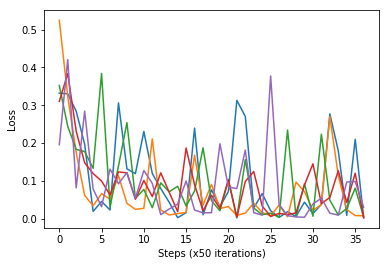

In [7]:
runs = 5

performance = []
loss_hist = []
for _ in range(runs):
    acc, losses = run_model()
    performance.append(acc)
    loss_hist.append(losses)
    
print("Average performance : ", np.mean(performance))
for losses in loss_hist:
    plt.plot(losses)
plt.xlabel('Steps (x50 iterations)')
plt.ylabel('Loss')
plt.show()